## Importando dependências

In [1]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Importando dataset e splitando em teste e treino

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    y = np.array(y, dtype=np.float64)
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header=1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header=1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header=1)
initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER, header=1)
# initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER, header=1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

binarize_dataset_labels(initial_dataset)

/root/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Criando modelo da rede neural

In [3]:
class Net:
    def build(self, shape = (41,), classes = 10):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        self.built = model
        return model
    
    def compile(self):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                           optimizer = 'adam',
                           metrics = ['accuracy'])

## Criando modelo do servidor

In [4]:
class Server:
    def __init__(self, num_clients, num_labels, input_shape, model = Net()):
        self.global_model = model
        self.num_clients = num_clients
        
        self.global_model.build(classes =num_labels, shape = input_shape)
        self.global_model.compile()
            
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            for weight in local_weights:
                scaled_weight = weight * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)

## Criando modelo do cliente

In [5]:
class Client:
    def __init__(self, client_id = 123, dataset = list(), model = Net(), num_labels = 10):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.9)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples}, random_state=0)
        return smote_oversample.fit_resample(X, y)
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        X, y = self.apply_oversample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2)
       
        
    def train_model(self):
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = 128,
                                   epochs=10, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        y_score = self.local_model.built.predict(self.X_test)[:,1]
        
        prec = precision_score(self.y_test, y_pred, average = 'micro')
        rec = recall_score(self.y_test, y_pred, average = 'micro')
        auc = roc_auc_score(self.y_test, y_score)
        self.report = classification_report(self.y_test, y_pred, zero_division=0)
        self.fpr, self.tpr, _ = roc_curve(self.y_test, y_score)
        
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test)
        
        self.metrics_history.append((loss, acc, prec, rec, auc))
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 
        print(self.report)
        
    def plot_result(self, rounds):
        loss_history, acc_history, prec_history, rec_history, auc_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy score')
        plt.legend()
        plt.show()
        
        plt.plot(epochs, prec_history, 'y', label='Precision')
        plt.plot(epochs, rec_history, 'k', label='Recall')
        plt.plot(epochs, auc_history, 'g', label='AUC')
        plt.title(f'Precision, Recall and AUC score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Precision, Recall and AUC score')
        plt.legend()
        plt.show()
        
        plt.plot(self.fpr, self.tpr, marker='.', label='Net classification')
        plt.title(f'ROC Curve of client {self.client_id}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [6]:
import random
def split_dataset_non_iid(clients, num_labels, input_shape):
        unique_ips = initial_dataset['srcip'].value_counts().head(100).keys()
        ips_range = len(unique_ips)
        client_index, id_list = (0,[])
        while client_index < num_clients:
            srcip_id = random.randint(0,ips_range-1)
            if srcip_id not in id_list:
                id_list.append(srcip_id)
                local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip_id]]
                value_counts = local_dataset['class'].value_counts()
                num_classes = len(value_counts)
                if num_classes > 1:
                    print(f"Value counts for client {client_index}\n{value_counts}")
                    clients[client_index].local_dataset = local_dataset
                    clients[client_index].num_labels = num_labels
                    clients[client_index].input_shape = input_shape
                    client_index += 1
            
            

num_clients = 30
train_rounds = 10
X = initial_dataset.iloc[:, 5:-1].values
y = initial_dataset.iloc[:, -1].values
num_labels = len(set(y))
input_shape = X.shape[1:]

server = Server(num_clients, num_labels, input_shape)
clients = [Client(client_id = i) for i in range(num_clients)]

split_dataset_non_iid(clients, num_labels, input_shape)

Value counts for client 0
0.0    49154
1.0     3340
Name: class, dtype: int64
Value counts for client 1
0.0    41103
1.0       46
Name: class, dtype: int64
Value counts for client 2
0.0    45580
1.0       15
Name: class, dtype: int64
Value counts for client 3
0.0    1047887
1.0     116968
Name: class, dtype: int64
Value counts for client 4
0.0    100494
1.0      2704
Name: class, dtype: int64
Value counts for client 5
0.0    47734
1.0       80
Name: class, dtype: int64
Value counts for client 6
0.0    39945
1.0    24763
Name: class, dtype: int64
Value counts for client 7
0.0    55848
1.0    51921
Name: class, dtype: int64
Value counts for client 8
0.0    39309
1.0      120
Name: class, dtype: int64
Value counts for client 9
0.0    99328
1.0     2639
Name: class, dtype: int64
Value counts for client 10
0.0    70102
1.0    13663
Name: class, dtype: int64
Value counts for client 11
0.0    32840
1.0      205
Name: class, dtype: int64
Value counts for client 12
0.0    113285
1.0        17
N

## Treinando e testando modelos NN locais

In [7]:
for client in clients:
    client.preprocess()

for i in range(train_rounds):
    local_clients_train = list()
    server.send_global_model_weights(clients)

    for client in clients:
        client.train_model()
        
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)
    
print(f"[INFO] All local trains are finished!")


[INFO] Local test of client 0
584/584 [==============================] - 0s 527us/step - loss: 0.4071 - accuracy: 0.8446
[[8945  920]
 [1982 6832]]
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      9865
         1.0       0.88      0.78      0.82      8814

    accuracy                           0.84     18679
   macro avg       0.85      0.84      0.84     18679
weighted avg       0.85      0.84      0.84     18679


[INFO] Local test of client 1
489/489 [==============================] - 0s 504us/step - loss: 0.0952 - accuracy: 0.9640
[[7773  563]
 [   0 7283]]
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97      8336
         1.0       0.93      1.00      0.96      7283

    accuracy                           0.96     15619
   macro avg       0.96      0.97      0.96     15619
weighted avg       0.97      0.96      0.96     15619


[INFO] Local test of client 2
542/542 [========

## Plotando resultados dos treinos locais

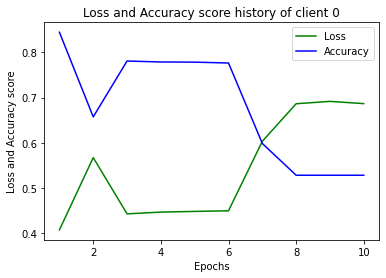

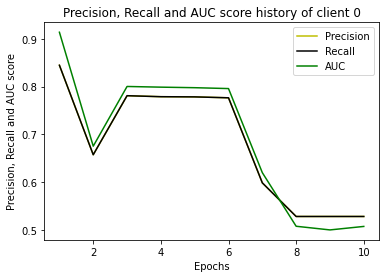

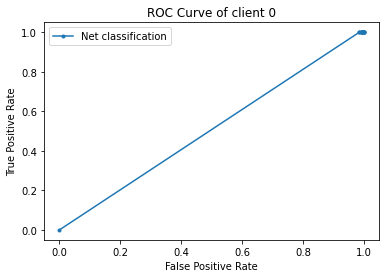

Class report of client 0
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      9865
         1.0       0.00      0.00      0.00      8814

    accuracy                           0.53     18679
   macro avg       0.26      0.50      0.35     18679
weighted avg       0.28      0.53      0.37     18679



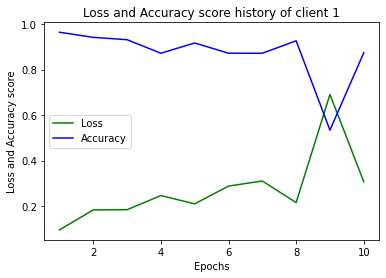

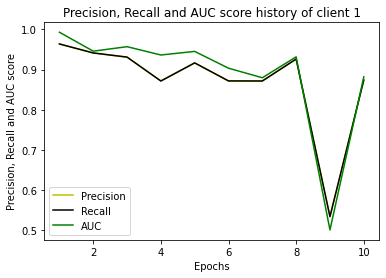

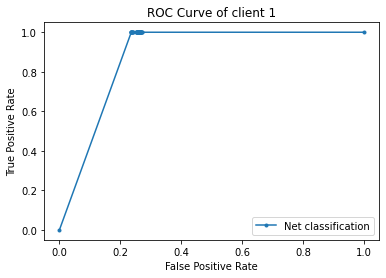

Class report of client 1
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.87      8336
         1.0       0.79      1.00      0.88      7283

    accuracy                           0.87     15619
   macro avg       0.89      0.88      0.87     15619
weighted avg       0.90      0.87      0.87     15619



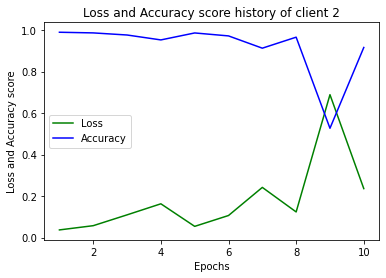

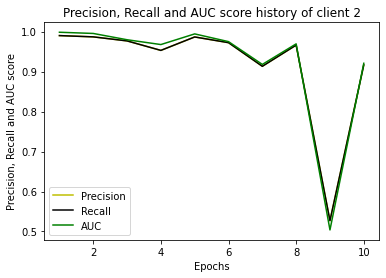

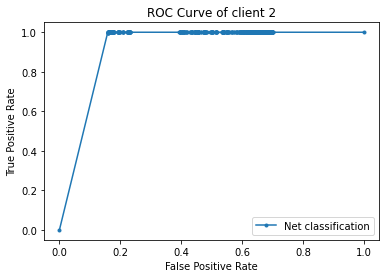

Class report of client 2
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      9130
         1.0       0.85      1.00      0.92      8191

    accuracy                           0.92     17321
   macro avg       0.92      0.92      0.92     17321
weighted avg       0.93      0.92      0.92     17321



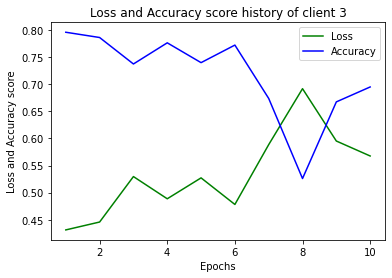

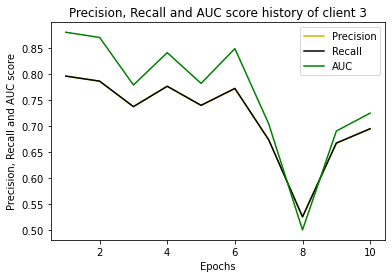

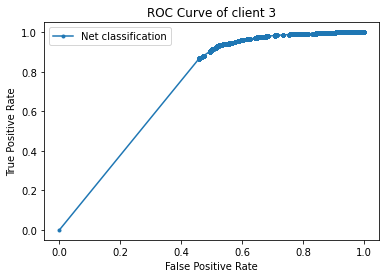

Class report of client 3
              precision    recall  f1-score   support

         0.0       0.86      0.50      0.63    209452
         1.0       0.62      0.91      0.74    188745

    accuracy                           0.69    398197
   macro avg       0.74      0.71      0.69    398197
weighted avg       0.75      0.69      0.68    398197



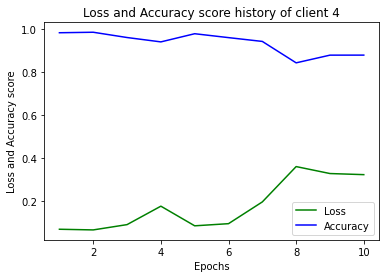

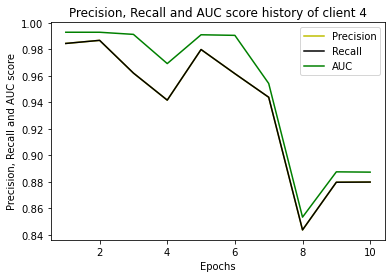

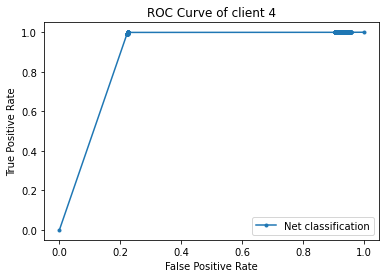

Class report of client 4
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87     20116
         1.0       0.80      0.99      0.89     18072

    accuracy                           0.88     38188
   macro avg       0.90      0.89      0.88     38188
weighted avg       0.90      0.88      0.88     38188



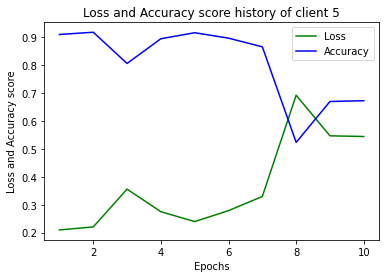

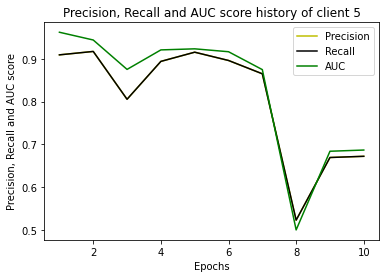

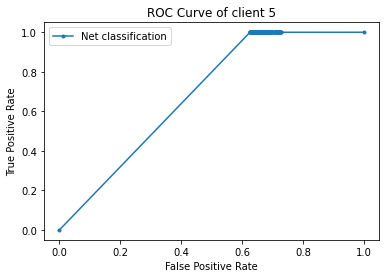

Class report of client 5
              precision    recall  f1-score   support

         0.0       1.00      0.37      0.54      9489
         1.0       0.59      1.00      0.74      8650

    accuracy                           0.67     18139
   macro avg       0.80      0.69      0.64     18139
weighted avg       0.81      0.67      0.64     18139



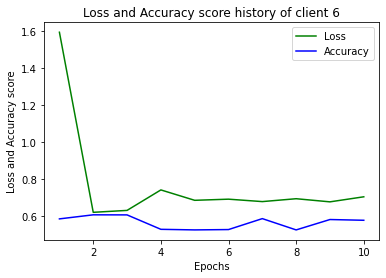

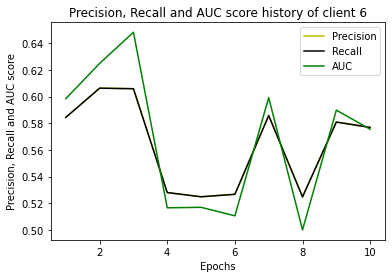

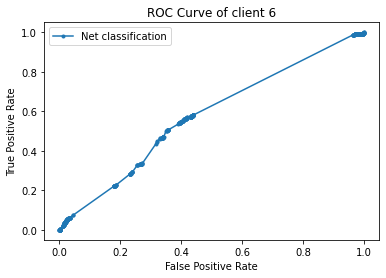

Class report of client 6
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.59      7965
         1.0       0.55      0.56      0.56      7214

    accuracy                           0.58     15179
   macro avg       0.58      0.58      0.58     15179
weighted avg       0.58      0.58      0.58     15179



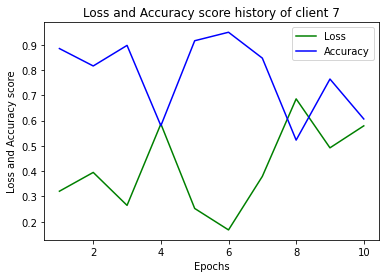

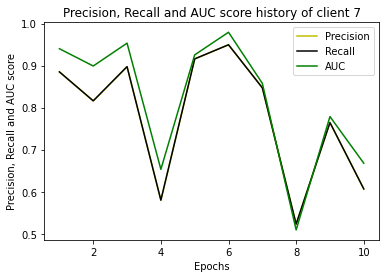

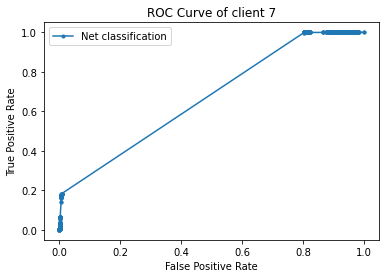

Class report of client 7
              precision    recall  f1-score   support

         0.0       0.57      0.99      0.73     11272
         1.0       0.96      0.18      0.31     10282

    accuracy                           0.61     21554
   macro avg       0.77      0.59      0.52     21554
weighted avg       0.76      0.61      0.53     21554



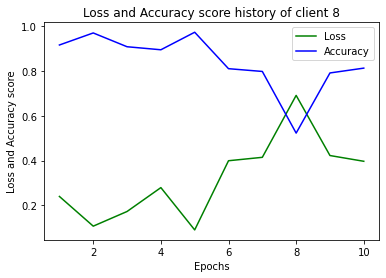

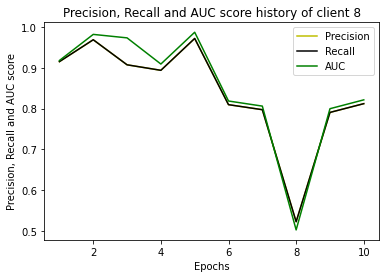

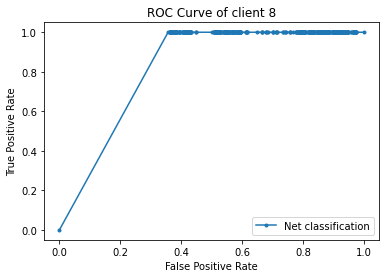

Class report of client 8
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78      7805
         1.0       0.72      1.00      0.84      7133

    accuracy                           0.81     14938
   macro avg       0.86      0.82      0.81     14938
weighted avg       0.87      0.81      0.81     14938



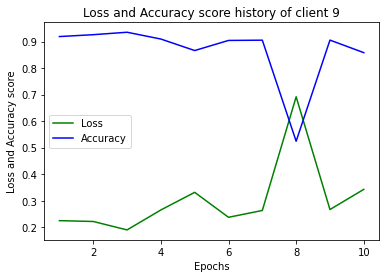

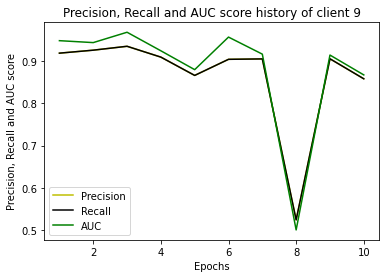

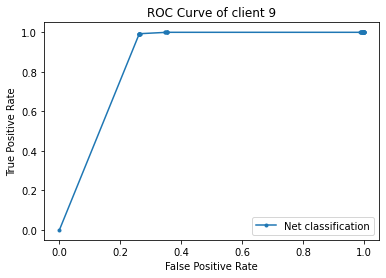

Class report of client 9
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     19787
         1.0       0.77      0.99      0.87     17958

    accuracy                           0.86     37745
   macro avg       0.88      0.86      0.86     37745
weighted avg       0.89      0.86      0.86     37745



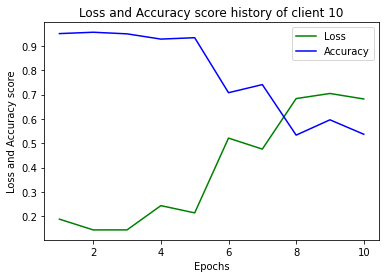

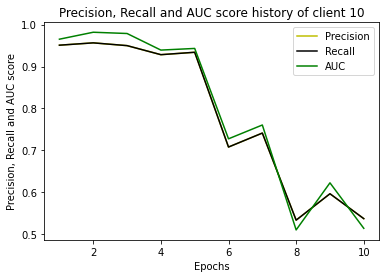

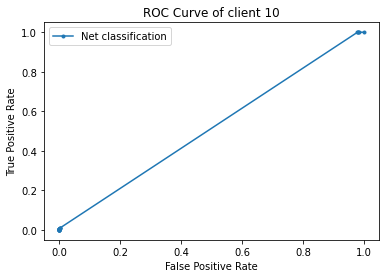

Class report of client 10
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70     14216
         1.0       0.95      0.01      0.02     12423

    accuracy                           0.54     26639
   macro avg       0.74      0.50      0.36     26639
weighted avg       0.73      0.54      0.38     26639



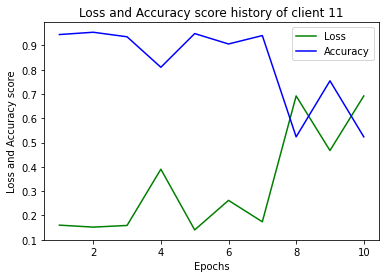

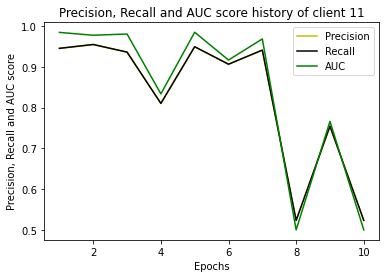

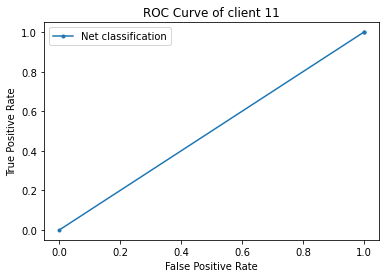

Class report of client 11
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.69      6533
         1.0       0.00      0.00      0.00      5947

    accuracy                           0.52     12480
   macro avg       0.26      0.50      0.34     12480
weighted avg       0.27      0.52      0.36     12480



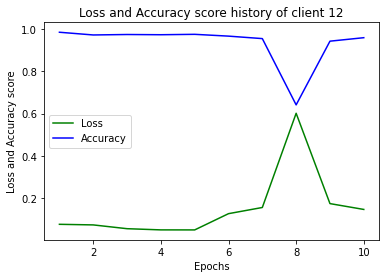

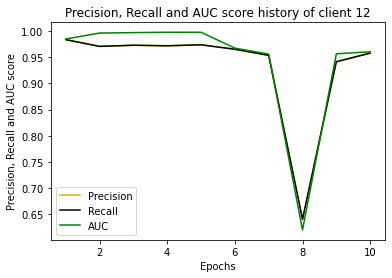

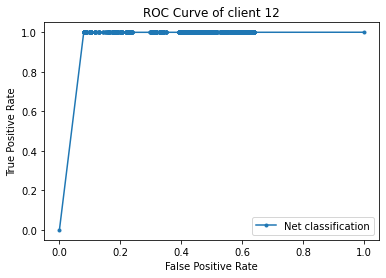

Class report of client 12
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     22690
         1.0       0.92      1.00      0.96     20359

    accuracy                           0.96     43049
   macro avg       0.96      0.96      0.96     43049
weighted avg       0.96      0.96      0.96     43049



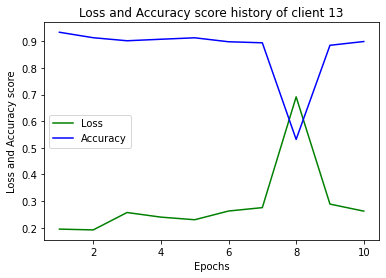

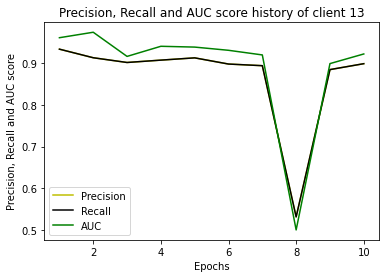

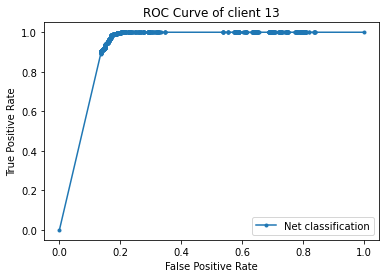

Class report of client 13
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      7415
         1.0       0.84      0.98      0.90      6537

    accuracy                           0.90     13952
   macro avg       0.91      0.90      0.90     13952
weighted avg       0.91      0.90      0.90     13952



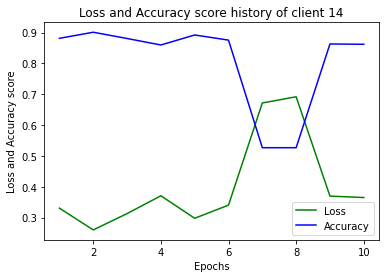

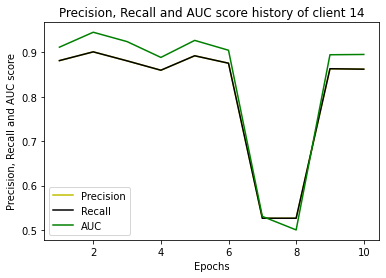

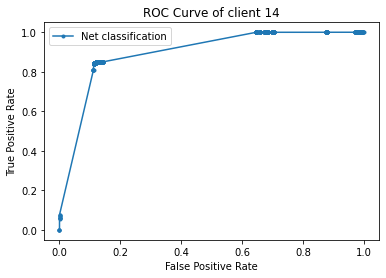

Class report of client 14
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     25402
         1.0       0.86      0.85      0.85     22846

    accuracy                           0.86     48248
   macro avg       0.86      0.86      0.86     48248
weighted avg       0.86      0.86      0.86     48248



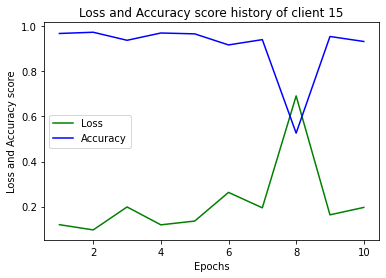

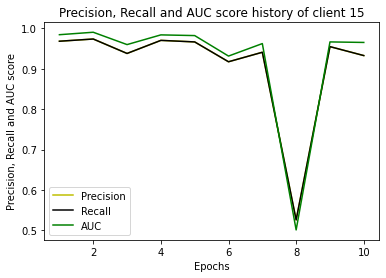

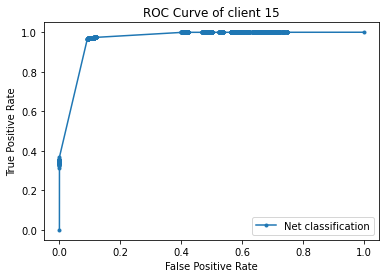

Class report of client 15
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93     29714
         1.0       0.90      0.97      0.93     26776

    accuracy                           0.93     56490
   macro avg       0.93      0.93      0.93     56490
weighted avg       0.94      0.93      0.93     56490



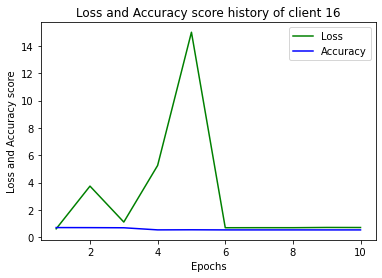

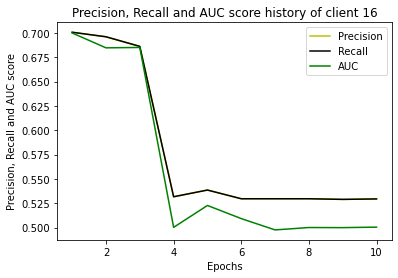

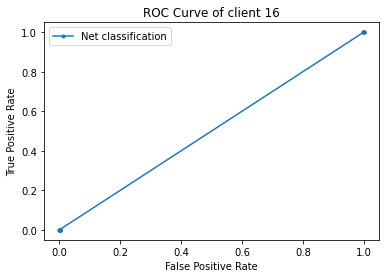

Class report of client 16
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      5684
         1.0       0.33      0.00      0.00      5049

    accuracy                           0.53     10733
   macro avg       0.43      0.50      0.35     10733
weighted avg       0.44      0.53      0.37     10733



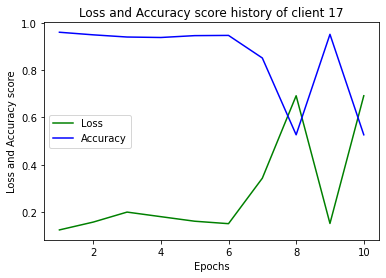

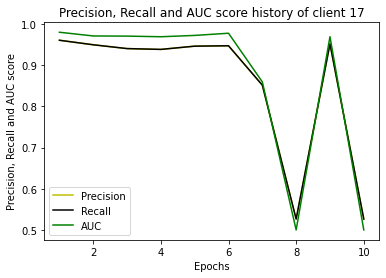

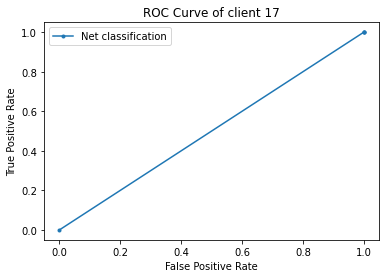

Class report of client 17
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69     39544
         1.0       0.00      0.00      0.00     35565

    accuracy                           0.53     75109
   macro avg       0.26      0.50      0.34     75109
weighted avg       0.28      0.53      0.36     75109



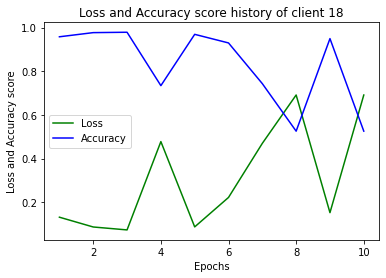

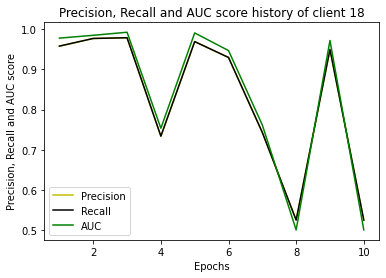

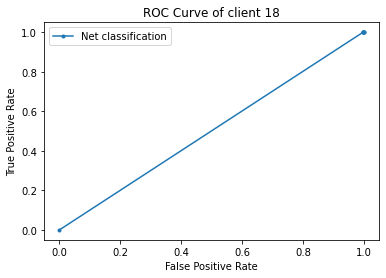

Class report of client 18
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      8441
         1.0       0.00      0.00      0.00      7620

    accuracy                           0.53     16061
   macro avg       0.26      0.50      0.34     16061
weighted avg       0.28      0.53      0.36     16061



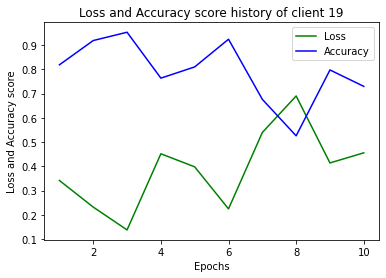

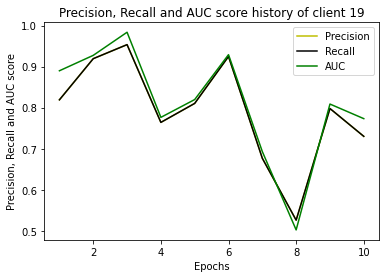

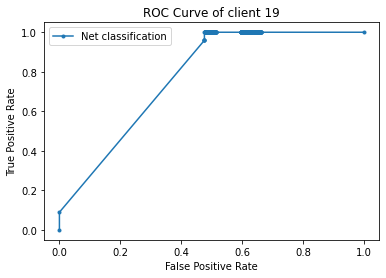

Class report of client 19
              precision    recall  f1-score   support

         0.0       0.93      0.52      0.67     11581
         1.0       0.64      0.96      0.77     10441

    accuracy                           0.73     22022
   macro avg       0.79      0.74      0.72     22022
weighted avg       0.80      0.73      0.72     22022



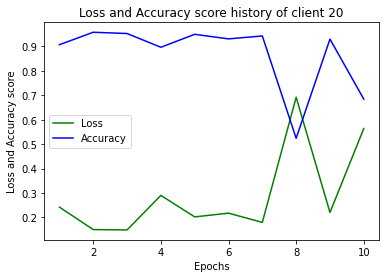

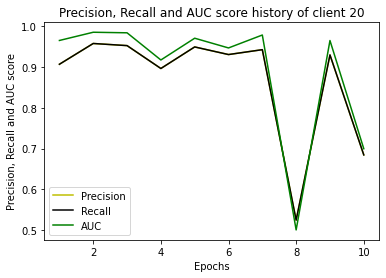

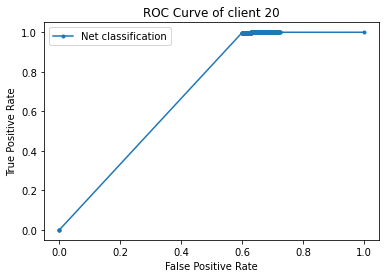

Class report of client 20
              precision    recall  f1-score   support

         0.0       0.99      0.40      0.57      9824
         1.0       0.60      1.00      0.75      8919

    accuracy                           0.68     18743
   macro avg       0.80      0.70      0.66     18743
weighted avg       0.81      0.68      0.66     18743



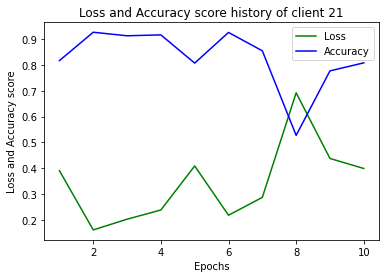

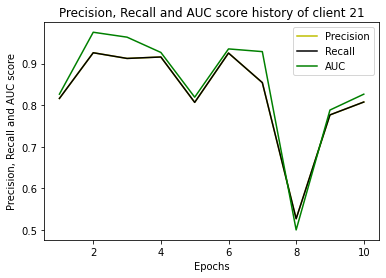

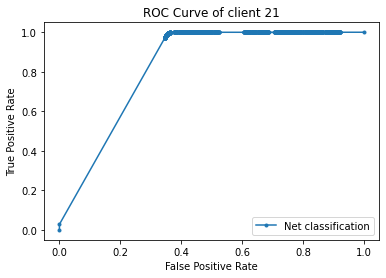

Class report of client 21
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     17816
         1.0       0.72      0.99      0.83     15996

    accuracy                           0.81     33812
   macro avg       0.85      0.82      0.80     33812
weighted avg       0.85      0.81      0.80     33812



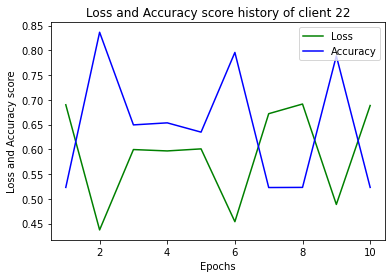

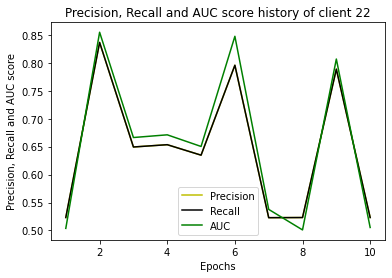

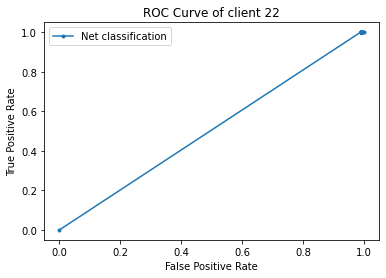

Class report of client 22
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.69     22108
         1.0       0.00      0.00      0.00     20153

    accuracy                           0.52     42261
   macro avg       0.26      0.50      0.34     42261
weighted avg       0.27      0.52      0.36     42261



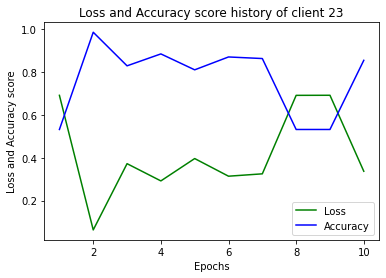

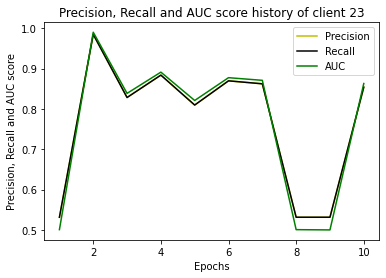

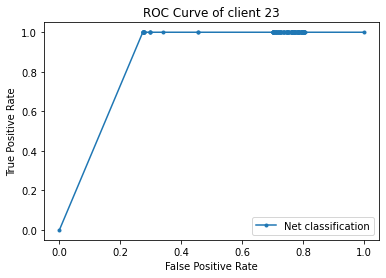

Class report of client 23
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      6776
         1.0       0.76      1.00      0.87      5971

    accuracy                           0.85     12747
   macro avg       0.88      0.86      0.85     12747
weighted avg       0.89      0.85      0.85     12747



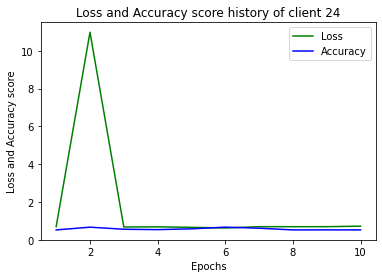

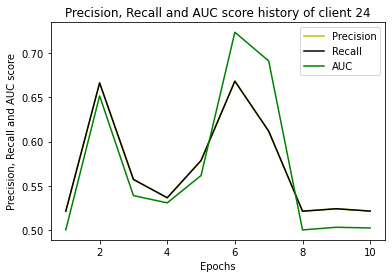

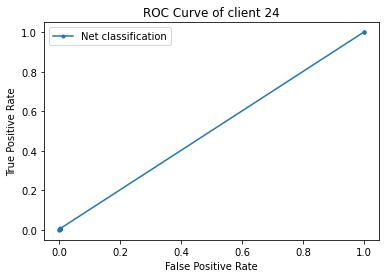

Class report of client 24
              precision    recall  f1-score   support

         0.0       0.75      0.00      0.00      3968
         1.0       0.52      1.00      0.69      4319

    accuracy                           0.52      8287
   macro avg       0.64      0.50      0.34      8287
weighted avg       0.63      0.52      0.36      8287



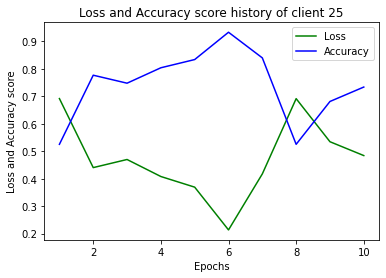

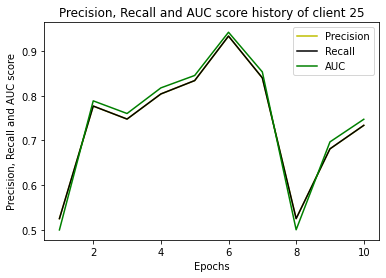

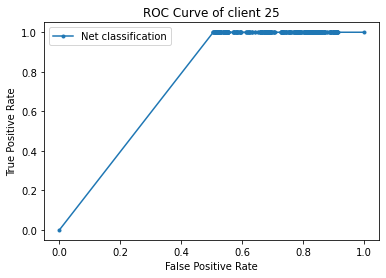

Class report of client 25
              precision    recall  f1-score   support

         0.0       1.00      0.49      0.66      7097
         1.0       0.64      1.00      0.78      6414

    accuracy                           0.73     13511
   macro avg       0.82      0.75      0.72     13511
weighted avg       0.83      0.73      0.72     13511



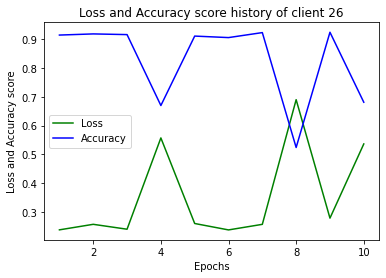

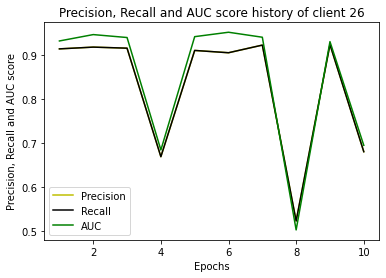

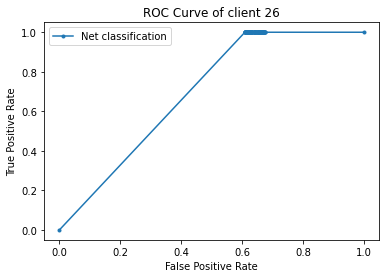

Class report of client 26
              precision    recall  f1-score   support

         0.0       1.00      0.39      0.56      8124
         1.0       0.60      1.00      0.75      7389

    accuracy                           0.68     15513
   macro avg       0.80      0.70      0.66     15513
weighted avg       0.81      0.68      0.65     15513



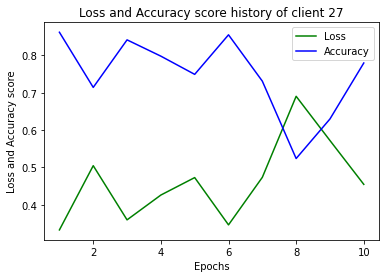

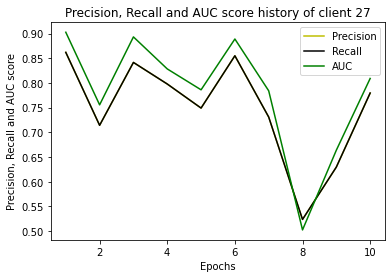

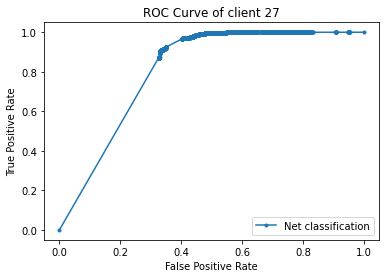

Class report of client 27
              precision    recall  f1-score   support

         0.0       0.90      0.65      0.76     17257
         1.0       0.71      0.92      0.80     15695

    accuracy                           0.78     32952
   macro avg       0.80      0.79      0.78     32952
weighted avg       0.81      0.78      0.78     32952



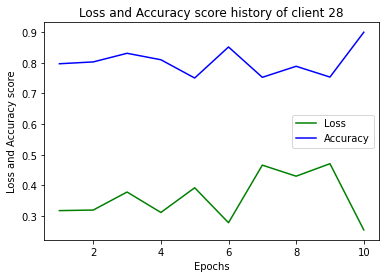

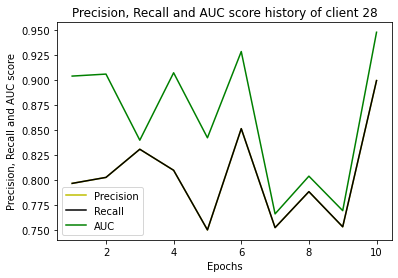

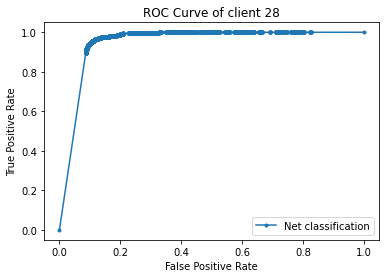

Class report of client 28
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     15920
         1.0       0.84      0.98      0.90     14301

    accuracy                           0.90     30221
   macro avg       0.91      0.90      0.90     30221
weighted avg       0.91      0.90      0.90     30221



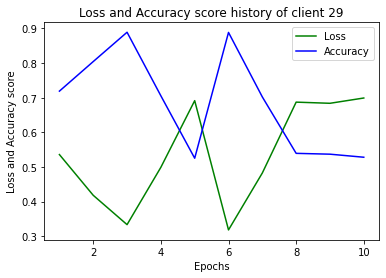

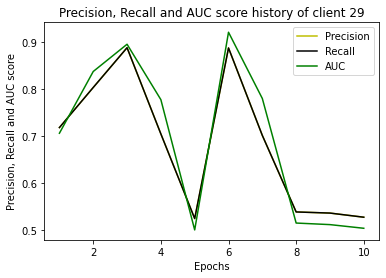

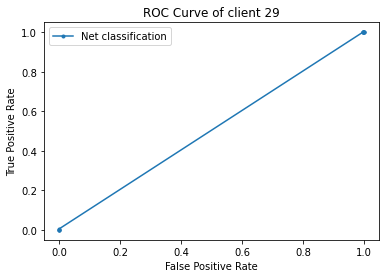

Class report of client 29
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69     11804
         1.0       0.99      0.01      0.01     10668

    accuracy                           0.53     22472
   macro avg       0.76      0.50      0.35     22472
weighted avg       0.74      0.53      0.37     22472



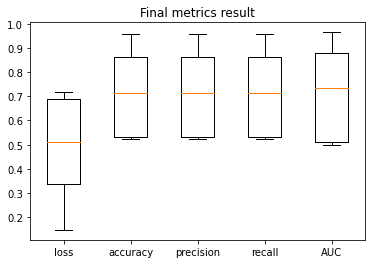

In [8]:
final_metrics = [[],[],[],[],[]]
for client in clients:
    client.plot_result(train_rounds)
    print(f"Class report of client {client.client_id}\n{client.report}")
    for i in range(5):
        final_metrics[i].append(client.metrics_history[-1][i])

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1,2,3,4,5], ['loss', 'accuracy', 'precision', 'recall', 'AUC'])
plt.show()